# Inferring Language Models (v2)

```yaml
Course:  DS 5001
Module:  03 Lab
Topic:   Inferring Language Models
Version: 2
Author:  R.C. Alvarado
Date:    22 January 2022 (modified)
```

## Purpose 

We create a series of word-level langage models from a set of novels and 
evaluate them.

This notebook uses classes.

## Set Up

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from IPython.core.display import HTML

Matplotlib is building the font cache; this may take a moment.


In [2]:
sns.set()

### Configure

In [3]:
import configparser

In [4]:
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [6]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
text_file = f'{output_dir}/austen-combo.csv'

## Import Data

Problem: These texts treat Mr. and Mrs. as sentences. Since sentence breaks are represented in the OHCO, to fix this requires reparsing the source text into the TOKEN table with the abbreviation periods removed.

Create Text object.

In [7]:
class Corpus():
    """Expects to have a tokenized text dataframe with OHCO as input."""
    
    TOKENS:pd.DataFrame # Expects to  have and OHCO index and token_str and term_str as columns
    VOCAB:pd.DataFrame # To be extracted from TOKENS
    
    def __init__(self, TOKENS:[]):
        self.TOKENS = TOKENS
        self.OHCO = TOKENS.index.names
        self.N = len(self.TOKENS)
        
    def extract_vocab(self):
        self.VOCAB = self.TOKENS.term_str.value_counts().to_frame('n').sort_index()
        self.VOCAB.index.name = 'term_str'
        self.VOCAB['n_chars'] = self.VOCAB.index.str.len()
        self.VOCAB['p'] = self.VOCAB.n / self.VOCAB.n.sum()
        self.VOCAB['i'] = np.log2(1/self.VOCAB.p)
        self.VOCAB['h'] = self.VOCAB.p * self.VOCAB.i
        self.H = self.VOCAB.h.sum()
        self.R = 1 - self.H / np.log2(len(self.VOCAB)) # H_max = log2(|V|)
        
    def extract_hapax_data(self):
        """Anticipating the language model, we find single instance words (hapaxes) and 
        describe them by charater length. We replace long and short hapaxes in this
        set with the value UNK since these have the most suprise."""
        
        # Create table of word lengths for all hapaxes
        self.hapaxes = self.VOCAB.query("n == 1").n_chars.value_counts().to_frame('n').sort_index() 
        self.hapaxes.index.name = 'n_chars'
        
        # Add prob features
        self.hapaxes['p'] = self.hapaxes.n / self.hapaxes.n.sum()
        self.hapaxes['s'] = 1 / self.hapaxes.p
        self.hapaxes['i'] = np.log2(self.hapaxes.s)
        self.hapaxes['h'] = self.hapaxes.p * self.hapaxes.i
        
        # Use prob features to select UNKs
        s_thresh = self.hapaxes.s.mean() # Could use quantiles ...
        unk_list = self.hapaxes[self.hapaxes.s > s_thresh].index.to_list()
        self.UNK = self.VOCAB[self.VOCAB.n_chars.isin(unk_list) & (self.VOCAB.n == 1)].index.to_list()        

In [8]:
TOKENS = pd.read_csv(text_file).set_index(OHCO).dropna()
TOKENS['term_str'] = TOKENS.token_str.str.lower().str.replace(r'[\W_]+', '', regex=True)
TOKENS = TOKENS[TOKENS.term_str != '']

In [9]:
training_corpus = Corpus(TOKENS)
training_corpus.extract_vocab()
training_corpus.extract_hapax_data()

In [10]:
training_corpus.hapaxes.style.background_gradient()

,n,p,s,i,h
n_chars,,,,,
1,6,0.001933,517.333333,9.014950,0.017426
2,8,0.002577,388.000000,8.599913,0.022165
3,35,0.011276,88.685714,6.470630,0.072961
4,152,0.048969,20.421053,4.351985,0.213113
5,294,0.094716,10.557823,3.400240,0.322059
6,397,0.127899,7.818640,2.966918,0.379467
7,477,0.153673,6.507338,2.702067,0.415234
8,478,0.153995,6.493724,2.699046,0.415639
9,452,0.145619,6.867257,2.779734,0.404781


## Create Models

In [11]:
class NgramModel():
    """Generate an n-gram model of lenght 1 to 3 from a list of tokens. 
    Expects a Corpus object containing a valid TOKENS dataframe. Will generate
    a language model at the level specificed as well as all lower level models."""
    
    sent_mark = '<s>', '</s>'
    unknown_term = '<UNK>'
    unknown_thresh = 1
    
    def __init__(self, CORPUS:Corpus, w:int = 3, unk_list:str=[]):
        self.CORPUS = CORPUS
        self.OHCO = list(CORPUS.TOKENS.index.names)
        self.w = w # Shlould check if in range
        self.unk_list = unk_list
        
    def make_index(self):
        """Generate all n-length combos (with values)"""
        
        print('Converting tokens to list of sentences ...')
        S = self.CORPUS.TOKENS.groupby(self.OHCO[:-1]).term_str\
            .apply(lambda x: x.str.cat(sep=' '))
        self.n_sents = len(S)
        
        print('Converting sentences to tokens with special tokens ...')
        self.K = S.apply(lambda x: pd.Series([self.sent_mark[0]] + x.split() + [self.sent_mark[1]]))\
            .stack().to_frame('term_str').reset_index(drop=True)
        self.n_tokens = len(self.K)
                
        print('Replacing rare words with UNK ...') # Should this happen here?
        self.K.loc[self.K.term_str.isin(self.unk_list), 'term_str'] = self.unknown_term
                
        print('Creating ngrams from offset lists ...')
        self.NG = pd.concat([self.K.shift(-i).term_str for i in range(self.w)], axis=1)
        self.widx = [f'w{i}' for i in range(self.w)]
        self.NG.columns = self.widx
                    
    def make_model(self):
        
        # A dictionary to store our models. 
        # We use a dict, not a list, to have 1-based indexing.
        self.M = {} 
        
        # Create models
        for i in range(self.w):
            level = self.w - i # We go backwards so we can get slices from the widx list
            print(f"Creating {level}-gram model ...")
            self.M[level] = self.NG.value_counts(self.widx[:level]).to_frame('n').sort_index()
             
        # Replace low-freq ngrams with UNKs ...
        for level in range(2, self.w + 1):
            print(f"Getting lo freqs for level {level}")
            unk_key = tuple(self.unknown_term for _ in range(level))
            self.M[level].loc[unk_key, 'n'] = self.M[level].query("n == 1").shape[0]
#             self.M[level] = self.M[level].query("n > 1") # Not the right approach
        
    def add_features(self):
        
        for level in range(1, self.w+1):
            print(f"Adding p, i, and h to {level}-gram model ...")        
            self.M[level]['p'] = self.M[level].n / self.M[level].n.sum()
            self.M[level]['i'] = np.log2(1/self.M[level].p)
            self.M[level]['h'] = self.M[level].p * self.M[level].i
            
        for level in range(2, self.w+1):
            print(f"Adding cp, ci, and ch to {level}-gram model ...")
            group_key = self.widx[:level-1]
            self.M[level]['cp'] = self.M[level].n / self.M[level].groupby(group_key).n.sum()
            self.M[level]['ci'] = np.log2(1 / self.M[level].cp)
            self.M[level]['ch'] = self.M[level].cp * self.M[level].ci
            self.M[level] = self.M[level].sort_index()
                                
    def do_all(self):       
        self.make_index()
        self.make_model()
        self.add_features()
        
    def predict_sentence(self, S):
        pass
            

In [12]:
LM = NgramModel(training_corpus, unk_list=training_corpus.UNK)

In [13]:
# LM.make_index()
# LM.make_model()
# LM.add_features()

In [14]:
LM.do_all()

Converting tokens to list of sentences ...
Converting sentences to tokens with special tokens ...
Replacing rare words with UNK ...
Creating ngrams from offset lists ...
Creating 3-gram model ...
Creating 2-gram model ...
Creating 1-gram model ...
Getting lo freqs for level 2
Getting lo freqs for level 3
Adding p, i, and h to 1-gram model ...
Adding p, i, and h to 2-gram model ...
Adding p, i, and h to 3-gram model ...
Adding cp, ci, and ch to 2-gram model ...
Adding cp, ci, and ch to 3-gram model ...


## Explore

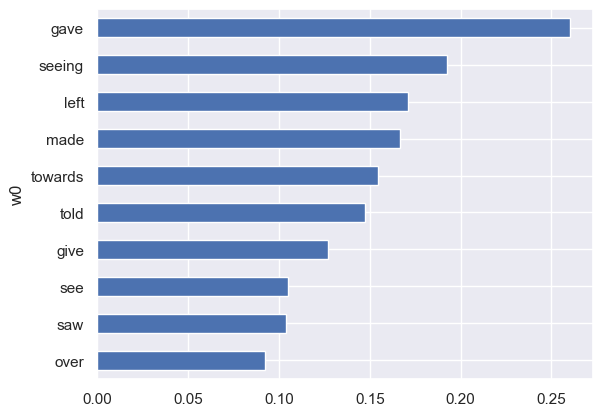

In [15]:
LM.M[2].xs('her', level=1).sort_values('n', ascending=False).head(30)\
    .sort_values('cp', ascending=True).tail(10).cp.plot.barh();

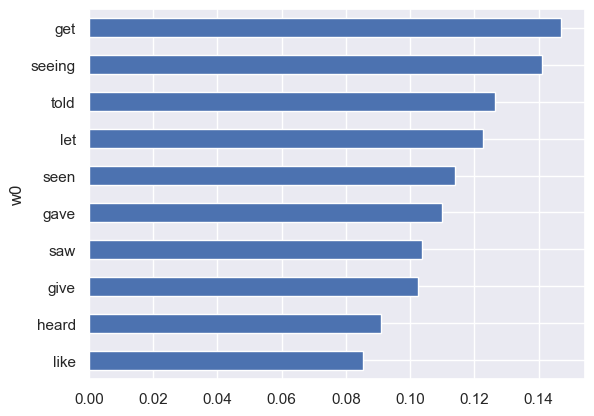

In [16]:
LM.M[2].xs('him', level=1).sort_values('n', ascending=False).head(30)\
    .sort_values('cp', ascending=True).tail(10).cp.plot.barh();

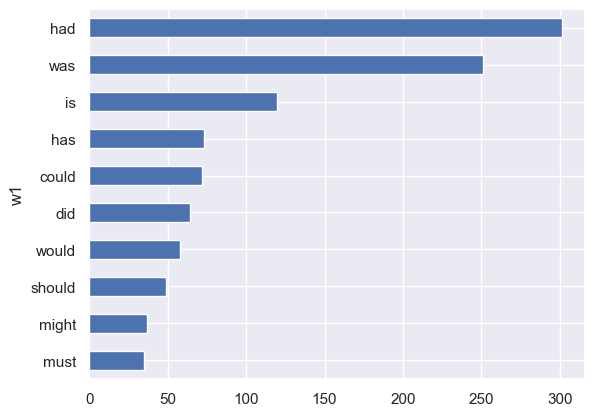

In [17]:
LM.M[2].loc['he'].n.sort_values().tail(10).plot.barh();

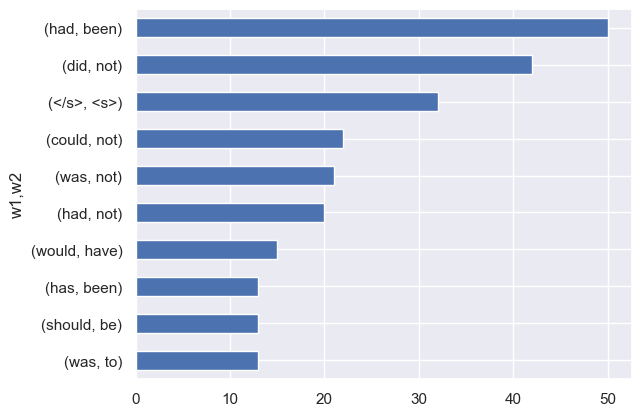

In [18]:
LM.M[3].loc['he'].n.sort_values().tail(10).plot.barh();

## Precict Sentences

### Prepare test data

Define list of test sentences.

In [19]:
# Some paragraphs from Austen's _Emma_
test_sentences = """
The event had every promise of happiness for her friend 
Mr Weston was a man of unexceptionable character easy fortune suitable age and pleasant manners
and there was some satisfaction in considering with what self-denying generous friendship she had always wished and promoted the match
but it was a black morning's work for her 
The want of Miss Taylor would be felt every hour of every day 
She recalled her past kindness the kindness the affection of sixteen years 
how she had taught and how she had played with her from five years old 
how she had devoted all her powers to attach and amuse her in health 
and how nursed her through the various illnesses of childhood 
A large debt of gratitude was owing here 
but the intercourse of the last seven years 
the equal footing and perfect unreserve which had soon followed Isabella's marriage 
on their being left to each other was yet a dearer tenderer recollection 
She had been a friend and companion such as few possessed intelligent well-informed useful gentle 
knowing all the ways of the family 
interested in all its concerns 
and peculiarly interested in herself in every pleasure every scheme of hers 
one to whom she could speak every thought as it arose 
and who had such an affection for her as could never find fault 
How was she to bear the change 
It was true that her friend was going only half a mile from them 
but Emma was aware that great must be the difference between a Mrs Weston 
only half a mile from them 
and a Miss Taylor in the house 
and with all her advantages natural and domestic 
she was now in great danger of suffering from intellectual solitude 
She dearly loved her father 
but he was no companion for her 
He could not meet her in conversation rational or playful 
The evil of the actual disparity in their ages
and Mr Woodhouse had not married early
was much increased by his constitution and habits 
for having been a valetudinarian all his life 
without activity of mind or body 
he was a much older man in ways than in years 
and though everywhere beloved for the friendliness of his heart and his amiable temper 
his talents could not have recommended him at any time 
Her sister though comparatively but little removed by matrimony 
being settled in London only sixteen miles off was much beyond her daily reach 
and many a long October and November evening must be struggled through at Hartfield 
before Christmas brought the next visit from Isabella and her husband 
and their little children to fill the house and give her pleasant society again 
""".split('\n')[1:-1]

Convert list to data frame.

In [20]:
TS = pd.DataFrame(dict(sent_str=test_sentences))
TS.index.name = 'sent_num'

Tokenize the sentences.

In [21]:
TEST_TOKENS = TS.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
TEST_TOKENS.index.names = ['sent_num', 'token_num']
TEST_TOKENS['term_str'] = TEST_TOKENS.token_str.str.lower().str.replace(r'\W+', '', regex=True)

In [22]:
TEST_TOKENS.head()

token_str term_str
sent_num token_num                   
0        0               The      the
         1             event    event
         2               had      had
         3             every    every
         4           promise  promise

Convert to Corpus Object.

In [23]:
test_corpus = Corpus(TEST_TOKENS)
test_corpus.extract_vocab()
test_corpus.extract_hapax_data() # No really used ...

In [24]:
# test_corpus.TOKENS.loc[3]

In [25]:
# test_corpus.UNK

### Generate test data

In [26]:
LMT = NgramModel(test_corpus, unk_list=training_corpus.UNK)
LMT.make_index()
LMT.make_model()

Converting tokens to list of sentences ...
Converting sentences to tokens with special tokens ...
Replacing rare words with UNK ...
Creating ngrams from offset lists ...
Creating 3-gram model ...
Creating 2-gram model ...
Creating 1-gram model ...
Getting lo freqs for level 2
Getting lo freqs for level 3


### Compare Models

In [27]:
class ModelComparator():
    
    def __init__(self, MODEL:NgramModel, TEST:NgramModel, w=3):
        """Compare two models, such as training and test models."""
        
        self.MODEL = MODEL
        self.TEST = TEST
        self.w = w
                    
    def compare(self):
        """Join model to data.""" 

        M = self.MODEL.M[self.w]
        T = self.TEST.M[self.w]

        # We use a right join to keep test data that was not found in training
        self.comp = M.join(T, how='right', rsuffix='_test')

        # Compute differences
        self.ng_intersection = self.comp[~self.comp.n.isna()].index.to_list()
        self.ng_difference = self.comp[self.comp.n.isna()].index.to_list()
        self.hits = round(len(self.ng_intersection) / len(self.comp), 2)

        # Handle OOV words
        unk_key = tuple('<UNK>' for _ in range(self.w))
        unk_add_n = self.comp[self.comp.n.isna()].n_test.sum()
        self.comp.at[unk_key, 'n_test'] += unk_add_n # Update number of UNK items
        self.comp = self.comp[~self.comp.n.isna()] # Remove misses
                        
        # Compute cross-entropy and perplexity of model
        N = self.comp.n_test.sum()
        if self.w > 1: 
            i_col = 'ci'
        else:
            i_col = 'i'
        self.LL = (self.comp[i_col] * self.comp.n_test).sum()
        self.CH = self.LL / N
        self.PP = np.power(2, self.CH)

In [28]:
C = {}
for i in range(1, 4):
    C[i] = ModelComparator(LM, LMT, i)
    C[i].compare()

In [29]:
C[3].comp.style.background_gradient()

In [30]:
for n in range(1, 4): print(n, C[n].LL, C[n].CH, C[n].PP)

1 4587.973858436094 8.656554449879422 403.5362450418705
2 1969.5968357164093 2.124699930654163 4.361123756505375
3 673.340338258245 0.6693243919068042 1.590328049084836


## Generate Text

We use stupid back-off to account for missing ngrams.

In [31]:
def generate_text(LM, n=250):
    
    # Get first words
    words = ['<s>']
    next_word = LM.M[2].loc[words[0]].sample(weights='cp').index.values[0]
    words.append(next_word)
    
    # Generate the rest of the text
    for i in range(n):
        try:
            bg = tuple(words[-2:])
            next_word = LM.M[3].loc[bg].sample(weights='cp').index.values[0]
        except: # Fallback if not found
            try:
                ug = words[-1]
                next_word = LM.M[2].loc[ug].sample(weights='cp').index.values[0]
            except: # Fallback if not found            
                next_word = LM.M[1].sample(weights='p').index.values[0][0]
        words.append(next_word)
    
    # Make printable text
    text = ' '.join(words)
    text = re.sub('<s>', '<li>', text)
    text = re.sub(' </s>', '.</li>', text)
    text = re.sub(' s ', "'s ", text)
    text = text.upper()
    display(HTML("<ol style=font-family:monospace;margin:1rem;>"+text+".</ol>"))

In [32]:
generate_text(LM, n=500)

## Save

In [33]:
path_prefix = f"{output_dir}/austen-combo"
training_corpus.TOKENS.to_csv(f"{path_prefix}-TOKENS-v2.csv")
training_corpus.VOCAB.to_csv(f"{path_prefix}-VOCAB-v2.csv")
training_corpus.hapaxes.to_csv(f"{path_prefix}-HAPAX-v2.csv")

In [34]:
with open(f"{path_prefix}-UNK-v2.txt", 'w') as outfile:
    outfile.write('\n'.join(training_corpus.UNK))

In [35]:
for n in range(1, 4):
    LM.M[n].to_csv(f"{path_prefix}-LM{n}-v2.csv")

## Smoothing

"What do we do with words that are in our vocabulary (they are not unknown words) but appear in a test set in an unseen context (for example they appear after a word they never appeared after in training)?" (Jurafsky and Martin)

How to generalize ngram models when training data lacks certain instances of ngrams.

Note that smoothing is expensive and not very effective.

In [36]:
UG = LM.M[1].copy()

In [37]:
N = UG.n.sum()
M = UG.n.count()

In [38]:
N, M

(232051, 8206)

### Unigram Case

#### LaPlace Smoothing

In [39]:
UG['laplace_n'] = UG.n + 1

In [40]:
# UG['laplace_p'] = UG.laplace_n / (N + M)
UG['laplace_p'] = UG.laplace_n / UG.laplace_n.sum()

In [41]:
UG

,n,p,i,h,laplace_n,laplace_p
w0,,,,,,
1,3,0.000013,16.239120,0.000210,4,0.000017
1760,1,0.000004,17.824082,0.000077,2,0.000008
1784,1,0.000004,17.824082,0.000077,2,0.000008
1785,1,0.000004,17.824082,0.000077,2,0.000008
1787,1,0.000004,17.824082,0.000077,2,0.000008
...,...,...,...,...,...,...
youth,22,0.000095,13.364651,0.001267,23,0.000096
youthful,3,0.000013,16.239120,0.000210,4,0.000017
zeal,7,0.000030,15.016727,0.000453,8,0.000033


#### Adjusted Count $c^{*}$ and $p^{*}$

In [42]:
UG['n_adj'] = (UG.laplace_n) * (N / (N + M))

In [43]:
UG['p_adj'] = UG.n_adj / N

In [44]:
UG

,n,p,i,h,laplace_n,laplace_p,n_adj,p_adj
w0,,,,,,,,
1,3,0.000013,16.239120,0.000210,4,0.000017,3.863380,0.000017
1760,1,0.000004,17.824082,0.000077,2,0.000008,1.931690,0.000008
1784,1,0.000004,17.824082,0.000077,2,0.000008,1.931690,0.000008
1785,1,0.000004,17.824082,0.000077,2,0.000008,1.931690,0.000008
1787,1,0.000004,17.824082,0.000077,2,0.000008,1.931690,0.000008
...,...,...,...,...,...,...,...,...
youth,22,0.000095,13.364651,0.001267,23,0.000096,22.214433,0.000096
youthful,3,0.000013,16.239120,0.000210,4,0.000017,3.863380,0.000017
zeal,7,0.000030,15.016727,0.000453,8,0.000033,7.726759,0.000033


#### Discounting

In [45]:
UG['disc'] = UG.n_adj / UG.n

<Axes: xlabel='w0'>

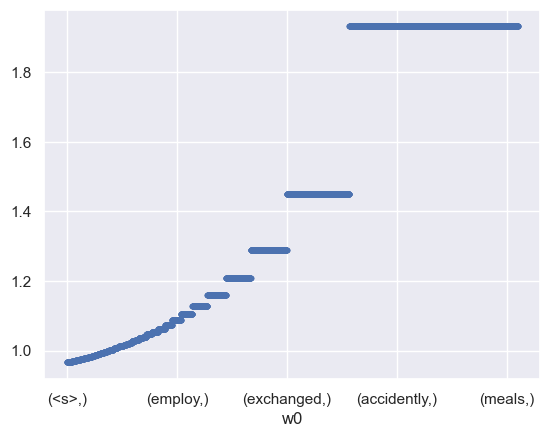

In [46]:
UG.disc.sort_values().plot(style='.')

### Bigram Case

In [47]:
BG = LM.M[2].n.unstack(fill_value=0).stack().to_frame('n')

In [48]:
len(BG)

67338436

In [49]:
BG

n
w0        w1            
1         1          0.0
          1760       1.0
          1784       0.0
          1785       1.0
          1787       0.0
...                  ...
zealously youth      0.0
          youthful   0.0
          zeal       0.0
          zealous    0.0
          zealously  0.0

[67338436 rows x 1 columns]

In [50]:
BG['p'] = BG.n / BG.n.sum()

#### LaPlace

In [51]:
BG['laplace_n'] = BG.n + 1

In [52]:
# BG

In [53]:
BG['laplace_p'] = BG.laplace_n / (BG.groupby('w0').laplace_n.sum())

In [54]:
# BG

#### Adjusted Count

In [55]:
BG['n_adj'] = (BG.laplace_n * BG.groupby('w0').n.sum()) / (BG.groupby('w0').laplace_n.sum())

In [56]:
# BG

#### Discounting

In [57]:
BG['disc'] = BG.n_adj / BG.laplace_n

#### Add K

In [58]:
k = .5
BG['addk_n'] = BG.n + k
BG['addk_p'] = BG.addk_n / (BG.groupby('w0').addk_n.sum())

In [59]:
BG

n         p  laplace_n  laplace_p     n_adj      disc  \
w0        w1                                                                   
1         1          0.0  0.000000        1.0   0.000122  0.000365  0.000365   
          1760       1.0  0.000003        2.0   0.000244  0.000731  0.000365   
          1784       0.0  0.000000        1.0   0.000122  0.000365  0.000365   
          1785       1.0  0.000003        2.0   0.000244  0.000731  0.000365   
          1787       0.0  0.000000        1.0   0.000122  0.000365  0.000365   
...                  ...       ...        ...        ...       ...       ...   
zealously youth      0.0  0.000000        1.0   0.000122  0.000244  0.000244   
          youthful   0.0  0.000000        1.0   0.000122  0.000244  0.000244   
          zeal       0.0  0.000000        1.0   0.000122  0.000244  0.000244   
          zealous    0.0  0.000000        1.0   0.000122  0.000244  0.000244   
          zealously  0.0  0.000000        1.0   0.000122  0.000244  0.000244   

                     addk_n    addk_p  
w0        w1                           
1         1             0.5  0.000122  
          1760          1.5  0.000365  
          1784          0.5  0.000122  
          1785          1.5  0.000365  
          1787          0.5  0.000122  
...                     ...       ...  
zealously youth         0.5  0.000122  
          youthful      0.5  0.000122  
          zeal          0.5  0.000122  
          zealous       0.5  0.000122  
          zealously     0.5  0.000122  

[67338436 rows x 8 columns]

#### Backoff and Interpolation

In [60]:
# BG.plot.scatter('laplace_p','addk_p')

## To Do

* Write a Tokenizer object that will work with a variety of formats and i/o options.
* Write a Corpus object that takes the results of Tokenizer
* Write a LanguageModel object

## Experiment

In [61]:
UG2 = LM.M[1].copy()
UG2.index = [item[0] for item in UG2.index] # Convert index from single item tuple
BG2 = LM.M[2].copy()
TG2 = LM.M[3].copy()

In [62]:
UG2['bgx'] = BG2.groupby('w1').n.count()\
    .reset_index().rename(columns={'w1':'w0'}).set_index('w0')

In [63]:
UG2['tgx'] = TG2.groupby('w1').n.count()\
    .reset_index().rename(columns={'w1':'w0'}).set_index('w0')

In [64]:
UG2.sort_values('bgx', ascending=False)

,n,p,i,h,bgx,tgx
</s>,13625,0.058716,4.090114,0.240153,2829,2829
and,6290,0.027106,5.205238,0.141094,1968,4697
of,6146,0.026486,5.238650,0.138749,1704,4993
to,6923,0.029834,5.066901,0.151166,1630,5483
in,3368,0.014514,6.106406,0.088629,1221,2684
...,...,...,...,...,...,...
exhibited,1,0.000004,17.824082,0.000077,1,1
publication,1,0.000004,17.824082,0.000077,1,1
publications,2,0.000009,16.824082,0.000145,1,2
publicity,1,0.000004,17.824082,0.000077,1,1


In [65]:
UG2.sort_values('tgx', ascending=False)

,n,p,i,h,bgx,tgx
to,6923,0.029834,5.066901,0.151166,1630,5483
the,7435,0.032040,4.963965,0.159047,1013,5261
of,6146,0.026486,5.238650,0.138749,1704,4993
and,6290,0.027106,5.205238,0.141094,1968,4697
</s>,13625,0.058716,4.090114,0.240153,2829,2829
...,...,...,...,...,...,...
entry,1,0.000004,17.824082,0.000077,1,1
entrusted,1,0.000004,17.824082,0.000077,1,1
entitle,1,0.000004,17.824082,0.000077,1,1
newness,1,0.000004,17.824082,0.000077,1,1


In [66]:
UG2['bgxp'] = UG2.bgx / UG2.bgx.sum()
UG2['tgxp'] = UG2.tgx / UG2.tgx.sum()
UG2['bgxh'] = UG2.bgxp * np.log2(1/UG2.bgxp)
UG2['tgxh'] = UG2.tgxp * np.log2(1/UG2.tgxp)

/Users/rca2t1/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


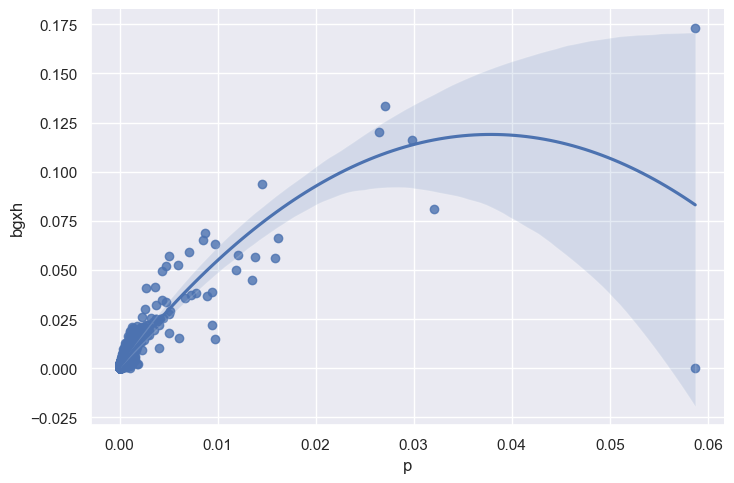

In [67]:
sns.lmplot(data=UG2, x='p', y='bgxh', aspect=1.5, order=2);

/Users/rca2t1/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


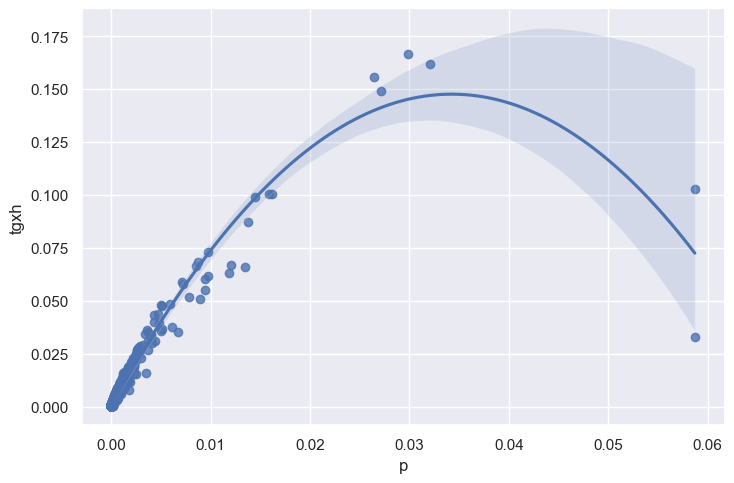

In [68]:
sns.lmplot(data=UG2, x='p', y='tgxh', aspect=1.5, order=2);